In [139]:
import arviz as az
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
trace = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-probit1_trace.netcdf')

In [45]:
from tms_risk.cogmodels.fit_probit import build_model

In [46]:
model, data = build_model(1)

In [47]:
def invprobit(x):
    return ss.norm.ppf(x)

In [48]:
def extract_rnp_precision(trace, model, data, group=False):

    data = data.reset_index()

    if group:
        fake_data = pd.MultiIndex.from_product([data.reset_index()['subject'].unique()[[0]],
                                                [0, 1],
                                                data['n_safe'].unique(),
                                                [False, True]],
                                                names=['subject', 'x', 'n_safe', 'risky_first']
                                                ).to_frame().reset_index(drop=True)
    else:
        fake_data = pd.MultiIndex.from_product([data.reset_index()['subject'].unique(),
                                                [0, 1],
                                                data['n_safe'].unique(),
                                                [False, True]],
                                                names=['subject', 'x', 'n_safe', 'risky_first']
                                                ).to_frame().reset_index(drop=True)

    pred = model.predict(trace, 'mean', fake_data, inplace=False)['posterior']['chose_risky_mean']

    pred = pred.to_dataframe().unstack([0, 1])
    pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

    # return pred

    pred0 = pred.xs(0, 0, 'x')
    intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
    gamma = invprobit(pred.xs(1, 0, 'x')) - intercept

    return intercept, gamma

In [66]:
intercept, gamma = extract_rnp_precision(trace, model, data, group=True)

In [136]:
intercept, gamma = extract_rnp_precision(trace, model, data, group=False)

In [159]:
rnp = np.clip(np.exp(intercept/gamma), 0.0, 1)
rnp.max().max()

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


1.0

In [160]:
import seaborn as sns

In [161]:
import matplotlib.pyplot as plt

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:74

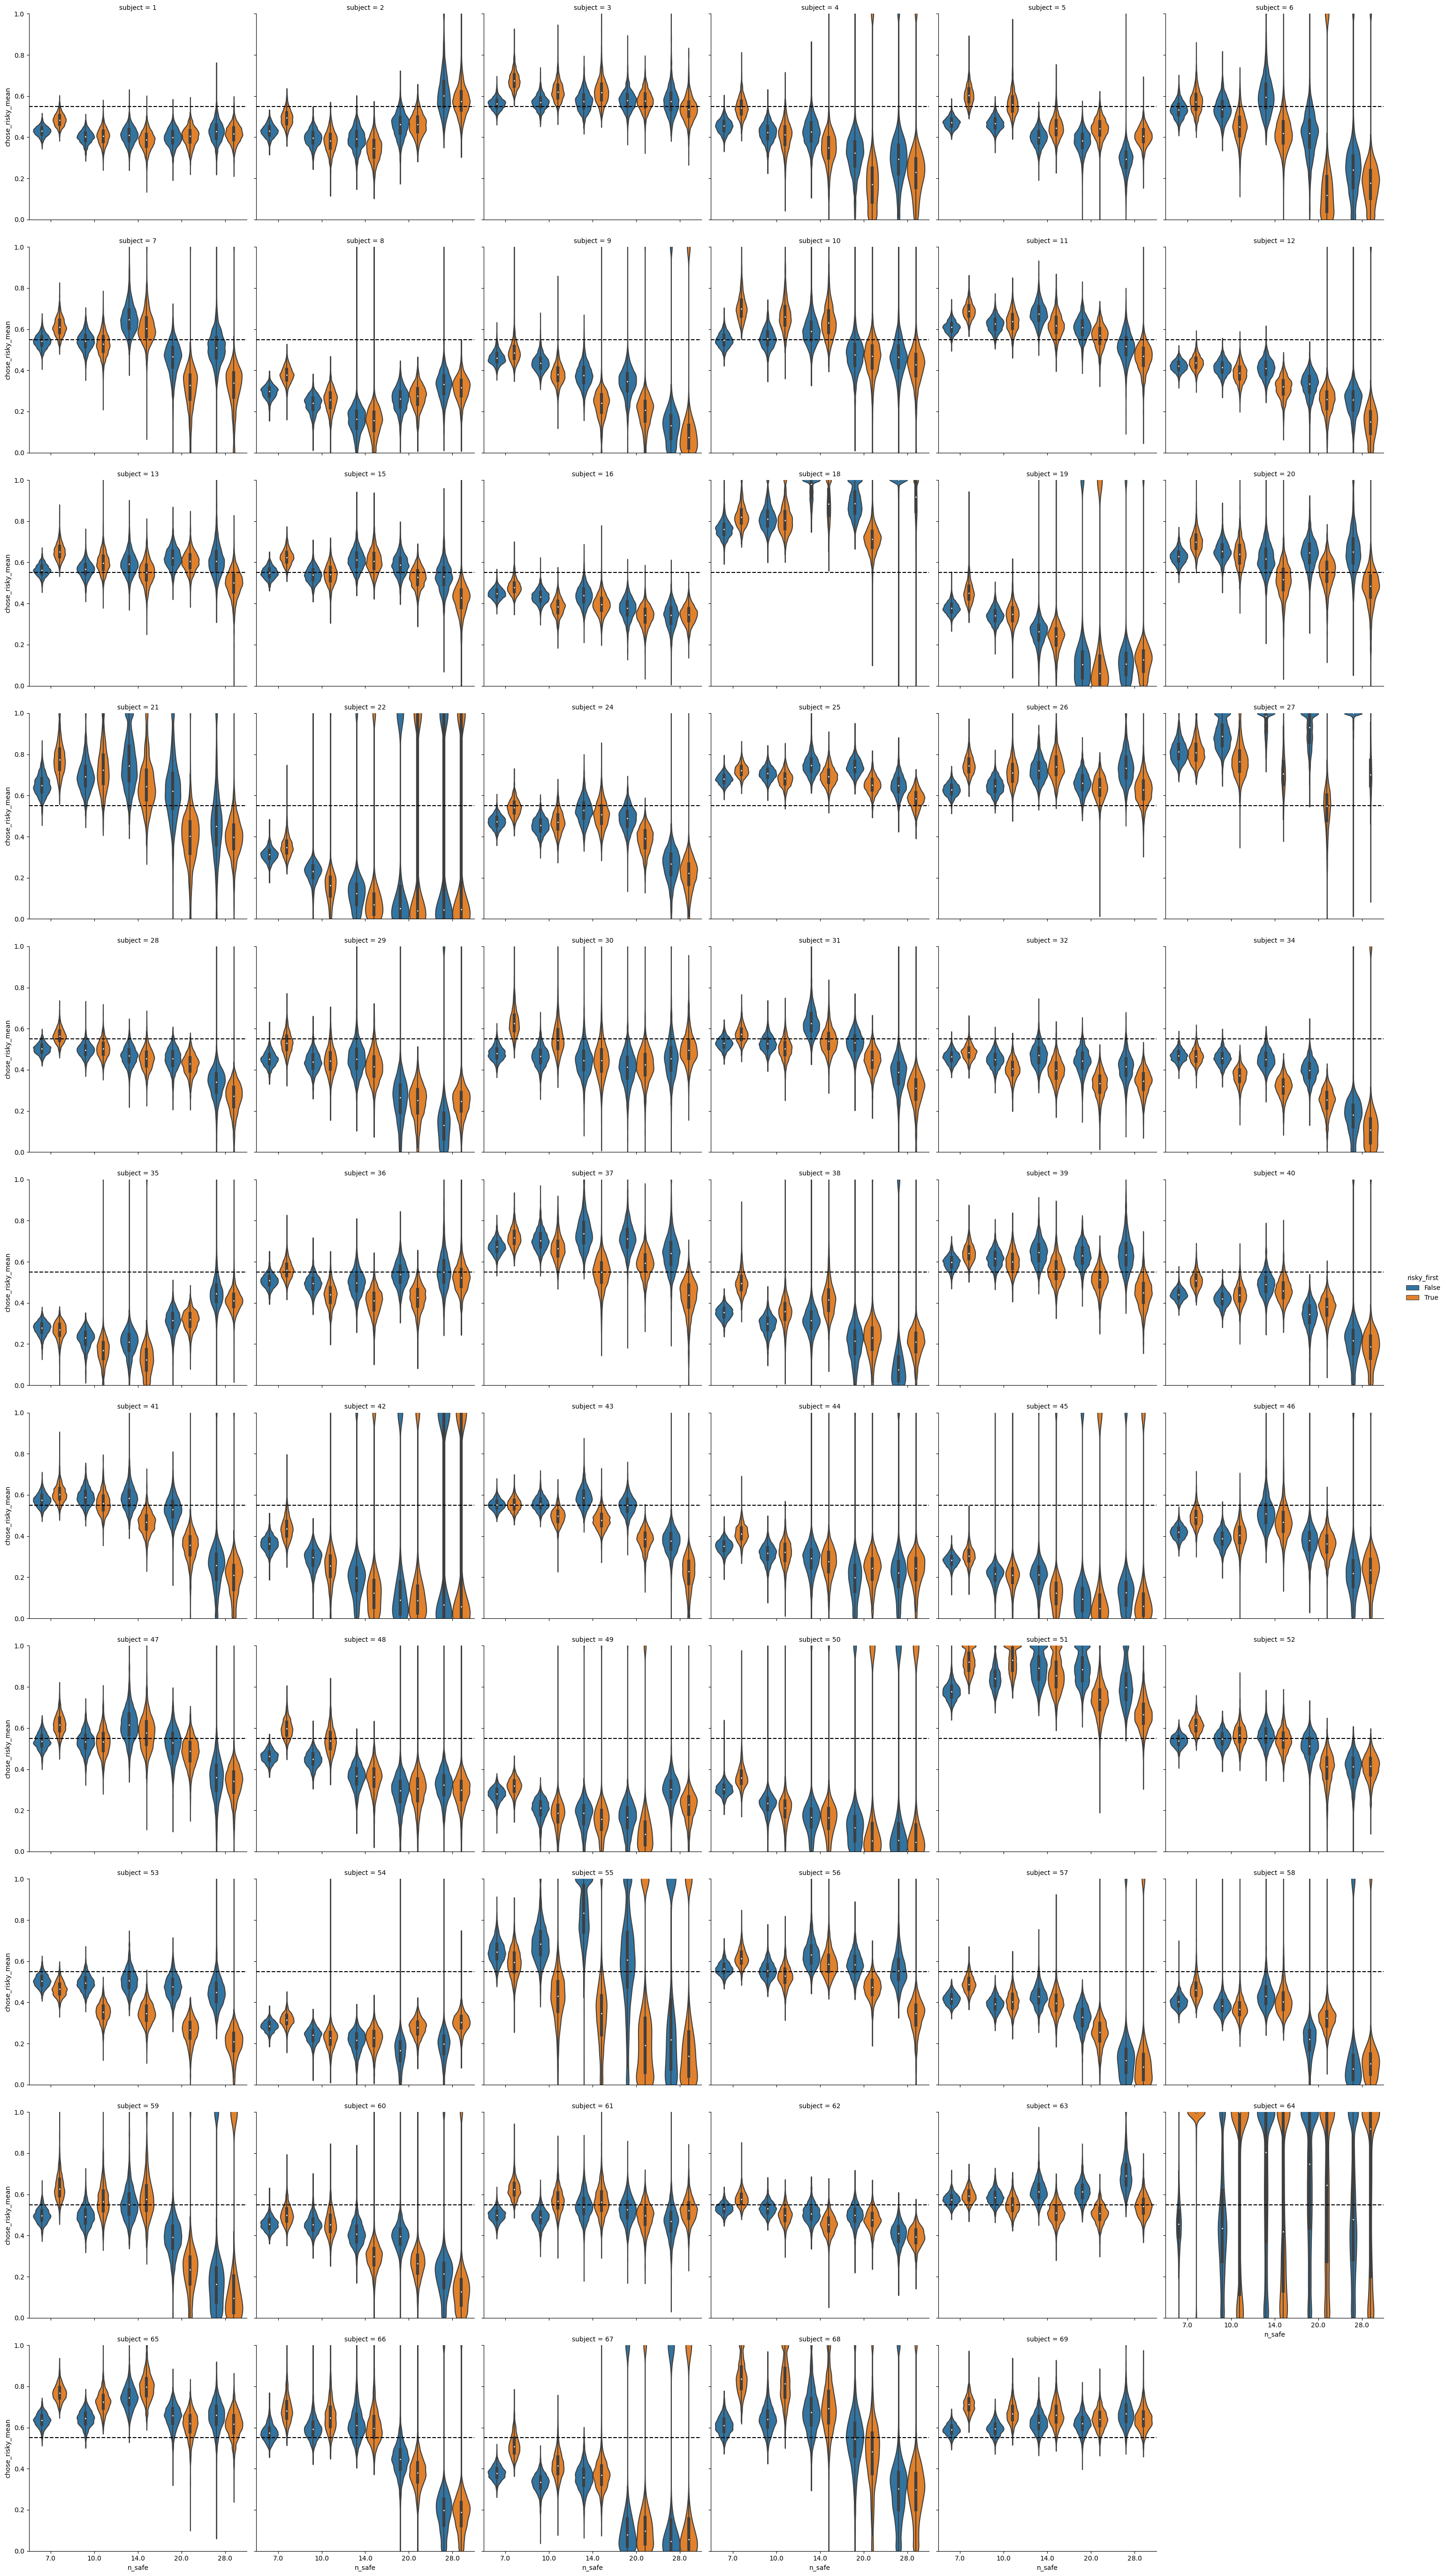

In [162]:
fac = sns.catplot(rnp.stack().stack().reset_index(), x='n_safe', y='chose_risky_mean', hue='risky_first', kind='violin', col='subject', col_wrap=6,
bw=.15, cut=True)
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.set(ylim=(0, 1))

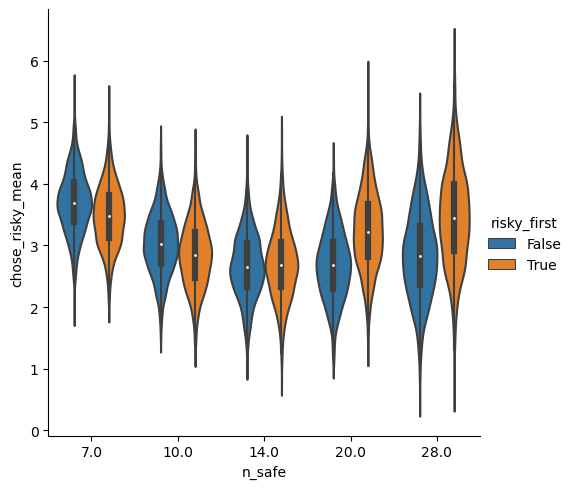

In [85]:
sns.catplot(gamma.stack().stack().reset_index(), x='n_safe', y='chose_risky_mean', hue='risky_first', kind='violin')

In [69]:
intercept.groupby(['n_safe', 'risky_first']).mean().mean(1)

n_safe  risky_first
7.0     False          0.506795
        True           0.322079
10.0    False         -0.007957
        True           0.299593
14.0    False          0.809733
        True           0.496129
20.0    False          0.361131
        True           0.144564
28.0    False          0.025858
        True          -0.393419
dtype: float64

In [99]:
ss.bernoulli([.1, .2]).rvs((4, 2))

array([[0, 1],
       [0, 0],
       [0, 0],
       [1, 0]])

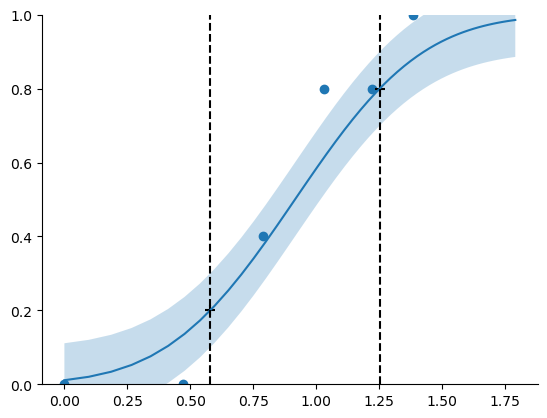

In [133]:
x = np.linspace(1, 6)

dist = ss.norm(np.log(2.5), .4)

y = dist.cdf(np.log(x))
plt.plot(np.log(x),y )

plt.fill_between(np.log(x), y-.1, y+.1, alpha=.25)
plt.ylim(0, 1)
x_ = np.log(np.linspace(1, 4, 6))
plt.scatter(x_, ss.bernoulli(dist.cdf(x_)).rvs((5, len(x_))).mean(0), color=sns.color_palette()[0])

plt.scatter(dist.ppf(.2), .2, marker='+', color='k', s=50)
plt.scatter(dist.ppf(.8), .8, marker='+', color='k', s=50)
# plt.axhline(.2, c='k', ls='--')
# plt.axhline(.8, c='k', ls='--')
plt.axvline(dist.ppf(.2), c='k', ls='--')
plt.axvline(dist.ppf(.8), c='k', ls='--')
sns.despine()

In [108]:
ss.bernoulli(dist.cdf(x_)).rvs((3, len(x_), ))

array([[0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [163]:
df

NameError: name 'df' is not defined

In [67]:
intercept.groupby(['subject']).mean().mean(1)

subject
1    -1.783871
2    -1.404085
3     2.193341
4     1.940017
5    -0.387874
        ...   
65    1.849730
66   -1.036062
67   -2.194252
68   -0.614080
69    2.176282
Length: 65, dtype: float64